# Homework 4: Predictive Process Monitoring

This goal of this homework is to train and use predictive process monitoring techniques to predict the outcome of a process from a log of events. Make the necessary modifications to the framework proposed by Taineema et al. reviewed in class to meet this goal.

### Libraries import and datetime fix

In [1]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline
from pandas_profiling import ProfileReport

Event log reading

In [3]:
log = pd.read_csv(os.path.join('input', 'turnaround_anon_sla.csv'))
log

,caseid,activity,start_timestamp,end_timestamp,SLA MIN
0,Case00,A0,2017-07-12 11:47:00,2017-07-12 11:48:00,35.0
1,Case00,A1,2017-07-12 11:57:00,2017-07-12 11:57:00,35.0
2,Case00,A2,2017-07-12 12:34:00,2017-07-12 12:34:00,35.0
3,Case00,A3,2017-07-12 11:57:00,2017-07-12 11:59:00,35.0
4,Case00,A4,2017-07-12 11:43:00,2017-07-12 11:43:00,35.0
...,...,...,...,...,...
2441,Case66,A27,2017-08-10 15:29:00,2017-08-10 15:37:00,45.0
2442,Case66,A28,2017-08-10 15:08:00,2017-08-10 15:19:00,45.0
2443,Case66,A30,2017-08-10 15:35:00,2017-08-10 15:41:00,45.0
2444,Case66,A31,2017-08-10 15:19:00,2017-08-10 15:19:00,45.0


In [4]:
# Timestamps format fix
log['start_timestamp'] = pd.to_datetime(log['start_timestamp'], infer_datetime_format=True)
log['end_timestamp'] = pd.to_datetime(log['end_timestamp'], infer_datetime_format=True)
log.head()

,caseid,activity,start_timestamp,end_timestamp,SLA MIN
0,Case00,A0,2017-07-12 11:47:00,2017-07-12 11:48:00,35.0
1,Case00,A1,2017-07-12 11:57:00,2017-07-12 11:57:00,35.0
2,Case00,A2,2017-07-12 12:34:00,2017-07-12 12:34:00,35.0
3,Case00,A3,2017-07-12 11:57:00,2017-07-12 11:59:00,35.0
4,Case00,A4,2017-07-12 11:43:00,2017-07-12 11:43:00,35.0


## Task 1

**(1 point)** As part of the log preprocessing, it is necessary to categorize the process traces as
deviant or regular. This log contains a column called SLA. it is a "case attribute," which indicates
how many minutes each case must complete. You must create a new column in the log that
contains a case attribute called label, which contains a value of 1 for deviant cases or 0 for
regular ones. This column's value is 0 if the duration of the case (in minutes) is less than or equal
to the SLA; otherwise, this column's value must be 1 (the SLA has not been met). NB! If there are
cases that do not have SLA, categorize them as 0. 

In [6]:
log['case_duration'] = 0
log['label'] = 0
log['is_start'] = False
log['is_end'] = False

for _, case in log.groupby('caseid'):
    # Assign case duration in mins to every row
    current_caseid = case['caseid'].min()
    
    case_start = case['start_timestamp'].min()
    case_end = case['end_timestamp'].max()
    case_duration = (case_end - case_start).total_seconds()//60
    is_deviant = int(case_duration > case['SLA MIN'].min())
    
    log.loc[log.caseid == current_caseid, 'case_duration'] = case_duration
    log.loc[log.caseid == current_caseid, 'label'] = is_deviant
    
    log.loc[(log.caseid == current_caseid) & (log.start_timestamp == case_start), 'is_start'] = True
    log.loc[(log.caseid == current_caseid) & (log.end_timestamp == case_end), 'is_end'] = True

log

,caseid,activity,start_timestamp,end_timestamp,SLA MIN,case_duration,label,is_start,is_end
0,Case00,A0,2017-07-12 11:47:00,2017-07-12 11:48:00,35.0,56,1,False,False
1,Case00,A1,2017-07-12 11:57:00,2017-07-12 11:57:00,35.0,56,1,False,False
2,Case00,A2,2017-07-12 12:34:00,2017-07-12 12:34:00,35.0,56,1,False,False
3,Case00,A3,2017-07-12 11:57:00,2017-07-12 11:59:00,35.0,56,1,False,False
4,Case00,A4,2017-07-12 11:43:00,2017-07-12 11:43:00,35.0,56,1,True,False
...,...,...,...,...,...,...,...,...,...
2441,Case66,A27,2017-08-10 15:29:00,2017-08-10 15:37:00,45.0,51,1,False,False
2442,Case66,A28,2017-08-10 15:08:00,2017-08-10 15:19:00,45.0,51,1,False,False
2443,Case66,A30,2017-08-10 15:35:00,2017-08-10 15:41:00,45.0,51,1,False,False
2444,Case66,A31,2017-08-10 15:19:00,2017-08-10 15:19:00,45.0,51,1,False,False


## Task 2

**(2 points)** Add a column to the event log that captures the WIP of the process at the moment where the last event in the prefix occurs. Remember that the WIP refers to the number of active cases, meaning the number of cases that have started but not yet completed. 

In [7]:
# Work in progress
# 1) order all records by start_timestamp, ascending
# 2) WIP = 0
# 3) iterate over all records:
#   if the starting record appears for the first time, increment WIP
#   if the ending record appears for the first time, decrement (but dont save WIP == 0)

log['WIP'] = 0;

log_sorted = log.sort_values(by=['start_timestamp'])
wip_count = 0
cases_in_progress = set()

for _, event in log_sorted.iterrows():
    if event['is_start'] == True and not event['caseid'] in cases_in_progress:
        # Add event to set and increment WIP
        wip_count += 1;
        cases_in_progress.add(event['caseid']);
    if event['is_end'] == True and event['caseid'] in cases_in_progress:
        wip_count -= 1;
        cases_in_progress.remove(event['caseid']);
        
    # Assign WIP value to relevant case and activity
    log.loc[(log.caseid == event.caseid) & (log.activity == event.activity), 'WIP'] = (wip_count or 1)

In [8]:
log

,caseid,activity,start_timestamp,end_timestamp,SLA MIN,case_duration,label,is_start,is_end,WIP
0,Case00,A0,2017-07-12 11:47:00,2017-07-12 11:48:00,35.0,56,1,False,False,1
1,Case00,A1,2017-07-12 11:57:00,2017-07-12 11:57:00,35.0,56,1,False,False,1
2,Case00,A2,2017-07-12 12:34:00,2017-07-12 12:34:00,35.0,56,1,False,False,1
3,Case00,A3,2017-07-12 11:57:00,2017-07-12 11:59:00,35.0,56,1,False,False,1
4,Case00,A4,2017-07-12 11:43:00,2017-07-12 11:43:00,35.0,56,1,True,False,1
...,...,...,...,...,...,...,...,...,...,...
2441,Case66,A27,2017-08-10 15:29:00,2017-08-10 15:37:00,45.0,51,1,False,False,1
2442,Case66,A28,2017-08-10 15:08:00,2017-08-10 15:19:00,45.0,51,1,False,False,1
2443,Case66,A30,2017-08-10 15:35:00,2017-08-10 15:41:00,45.0,51,1,False,False,1
2444,Case66,A31,2017-08-10 15:19:00,2017-08-10 15:19:00,45.0,51,1,False,False,1


In [9]:
# Remove temporary columns from the dataframe
log.drop(columns=['case_duration', 'is_start', 'is_end'], inplace=True)
log.head()

,caseid,activity,start_timestamp,end_timestamp,SLA MIN,label,WIP
0,Case00,A0,2017-07-12 11:47:00,2017-07-12 11:48:00,35.0,1,1
1,Case00,A1,2017-07-12 11:57:00,2017-07-12 11:57:00,35.0,1,1
2,Case00,A2,2017-07-12 12:34:00,2017-07-12 12:34:00,35.0,1,1
3,Case00,A3,2017-07-12 11:57:00,2017-07-12 11:59:00,35.0,1,1
4,Case00,A4,2017-07-12 11:43:00,2017-07-12 11:43:00,35.0,1,1


In [10]:
# Save the preprocessed input to labeled_logs_csv_processed folder
sorted_log = log.sort_values(by=['start_timestamp'])
sorted_log.to_csv(os.path.join('labeled_logs_csv_processed', 'turnaround_labeled.csv'), sep = ';')

## Task 3

**(4 points)** Currently, the work proposed by Taineema et al. performs the extraction of the prefixes of the traces registered in the log to train the classification models. For large logs, this approach leads to an increase in the dimensionality of the models' input (too many features) without necessarily improving its precision, especially in cases in which the event traces are very long.
You must modify this technique to extract subsequences of size n (n-grams), where n is a userdefined parameter, instead of encoding entire prefixes. An n-gram is a contiguous sequence of n items from a given trace.

In [11]:
# The N-gram method is introduced in the modified DatasetManager.py file, which is in the HW root
# Here is the standalone representation (not integrated in DatasetManager class)
def generate_ngram_data(data, n_size = 4, gap = 1):
    # Create empty result dataframe with same columns as input
    result = pd.DataFrame().reindex(columns=data.columns)
    result[event_nr_col] = None
    result[orig_case_id_col] = None
    result[shift_col] = None
    
    
    # Iterate over all cases
    for case_id in data[case_id_col].unique():
        # Get all events for the current case_id sorted by timestamp
        case_data = data[data[case_id_col] == case_id].sort_values([timestamp_col], ascending=True, kind='mergesort')
        case_data.insert(len(case_data.columns), event_nr_col, range(1, len(case_data) + 1))
        
        # Getting the original row indexes to use in N-gram copying
        event_indexes = case_data.index.values
        # If the provided n_size is bigger than the case lengtn, set N as case length
        N = min(n_size, len(event_indexes))
        
        # Get all N-grams for events in the current case
        ngrams_indexes = list(ngrams(event_indexes, N))
        
        for i in range(0, len(ngrams_indexes), gap):
            # Get the subset relevant to current N-gram in the original dataset
            ngram_subset_df = case_data.loc[list(ngrams_indexes[i])].copy()
            # Assign the original case id (just in case)
            ngram_subset_df[orig_case_id_col] = ngram_subset_df[case_id_col]
            ngram_subset_df[shift_col] = i
            # Modify case ID column to remain unique (concatenating N-gram number to the end)
            ngram_subset_df[case_id_col] = ngram_subset_df[case_id_col].apply(lambda x: "%s_%s"%(x, i))
            # Concatenate the N-gram subset to the result
            result = pd.concat([result, ngram_subset_df], axis=0)
    
    return result

## Task 4

**(3 points)** Test the results of your modifications with the Turnaround process event log using
cluster bucketing, index encoding, and the XGboost model.

Execution of the new n-gram method is introduced in the modified in the modified `optimize_params.py` file, which is in the HW root

Basically, instead of calling 
```python
dt_prefixes.append(dataset_manager.generate_prefix_data(test_chunk, min_prefix_length, max_prefix_length))
```
we call
```python
dt_prefixes.append(dataset_manager.generate_ngram_data(test_chunk))
```

In addition, `dataset_confs.py` was updated, a new configuration for `turnaround_labeled.csv` was introduced:
```python
#### NEW TURNAROUND LABELED Config ####
dataset = 'turnaround_labeled'
filename[dataset] = os.path.join(logs_dir, "%s.csv" % dataset)

case_id_col[dataset] = "caseid"
activity_col[dataset] = "activity"
timestamp_col[dataset] = "start_timestamp"
label_col[dataset] = "label"
pos_label[dataset] = '1'
neg_label[dataset] = '0'

# features for classifier
dynamic_cat_cols[dataset] = ['activity'] # i.e. event attributes
static_cat_cols[dataset] = [] # i.e. case attributes that are known from the start
dynamic_num_cols[dataset] = ['WIP', 'event_nr']
static_num_cols[dataset] = ['SLA MIN']
```

After those modifications were applied, it became possible to run `optimize_params.py` for a new dataset to get optimal parameters for a model based on cluster bucketing, index encoding, and the XGboost model.

**To start the optimizer, execute this command in the root HW folder** (10 is number of iterations):
`python3 optimize_params.py "turnaround_labeled" "output" "10" "cluster" "index" "xgboost"`

The outcomes of the execution are saved in `output` folder

### Complete execution

In [14]:
params_xgb = pd.read_csv(os.path.join('output', 'param_optim_all_trials_xgboost_turnaround_labeled_cluster_index.csv'), sep=';')

#parms = pd.concat([parms_rf, parms_xgb], axis=0, ignore_index=True)
params_xgb = params_xgb[['iter', 'cls', 'score']].drop_duplicates()
params_xgb = params_xgb[params_xgb.score!=0]
params_xgb.head()

,iter,cls,score
0,2,xgboost,0.916984
7,3,xgboost,0.602043
14,4,xgboost,0.529051
21,5,xgboost,0.879651
28,6,xgboost,0.531015


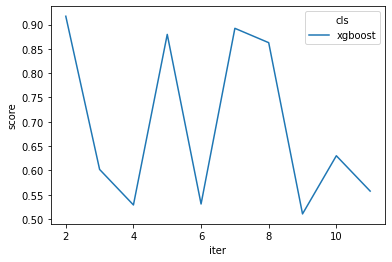

In [17]:
# Prediction accuracy for different optimisation iterations
g = sns.lineplot(data=params_xgb, x='iter', y='score', hue='cls')

A new concept of **N-gram shift** is basically an integer value describing what index of the original array the current N-gram starts from. For example, having an array [a, b, c, d], there are 3 2-grams: [a, b] (shift = 0), [b,c] (shift = 1), and [c,d] (shift = 2).

To be able to run N-gram shift based analysis (similar to prefix size based analysis), we also had to apply some updates to the source code:
1. Introduce new method `get_ngram_shifts()` in `DatasetManager.py`, similar to `get_prefix_lengths()` but based on N-gram shift.
2. In `experiments.py`, replace `nr_events_all.extend(list(dataset_manager.get_prefix_lengths(dt_test_bucket)))` with `nr_events_all.extend(list(dataset_manager.get_ngram_shifts(dt_test_bucket)))`
3. In `experiments.py`, replace `dataset_manager.get_prefix_lengths()` calls with `dataset_manager.get_ngram_shifts()` calls

After those modifications were applied, it became possible to run `experiments.py` for a new dataset to model scores based on N-gram shift.

**To start this, execute this command in the root HW folder** (10 is number of iterations):
`python3 experiments.py "turnaround_labeled" "output" "output" "cluster" "index" "xgboost" "1" "10"`

The outcomes of the execution are also saved in `output` folder

**!NB** Please note that default N-gram size is 4 

In [22]:
r_xgb = pd.read_csv(os.path.join('output', 'performance_results_xgboost_turnaround_labeled_cluster_index.csv'), sep=';')

r_xgb = r_xgb[r_xgb.metric=='auc']
r_xgb = r_xgb[r_xgb.nr_events!=-1]
r_xgb.rename(columns={"nr_events": "ngram_shift"}, inplace=True)
r_xgb.head()

,dataset,method,cls,ngram_shift,n_iter,metric,score
41,turnaround_labeled,cluster_index,xgboost,0,-1,auc,0.8750
42,turnaround_labeled,cluster_index,xgboost,1,-1,auc,1.0000
43,turnaround_labeled,cluster_index,xgboost,2,-1,auc,0.9875
44,turnaround_labeled,cluster_index,xgboost,3,-1,auc,0.9125
45,turnaround_labeled,cluster_index,xgboost,4,-1,auc,0.7750


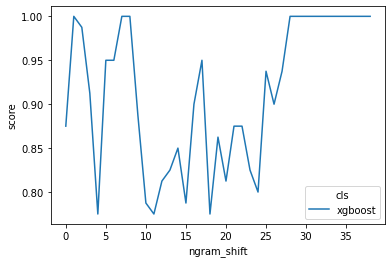

In [21]:
# FINAL RESULTS according to the N-gram shift

g = sns.lineplot(data=r_xgb, x='ngram_shift', y='score', hue='cls')
# According to the lone plot, the best accuracy (1.0) was found for 4-gram shifts 1, 7, 8, and from 28 to 38 
